# This Notebook will go over how CNN was used, what the dataset is and a function to display output.
- CNN was used to ----
- The dataset is --------
- How the function works and what is the output could be -------

In [39]:
# imports 
import torch # This is the core library for deep learning
import torch.nn as nn # This is the Neural Network models (layers, loss function, etc)
import torch.optim as optim # Optimization algorithms
from torch.utils.data import DataLoader # Utilities for handling the dataset
from torchvision import transforms, datasets # Image transformations and pre-trained models for computer vision
from sklearn.metrics import classification_report, confusion_matrix # Metrics for evaluating model performance (e.g., confusion matrix, classification report)
from matplotlib import pyplot as plt
import seaborn as sns  

In [40]:
import numpy as np

def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation of a dataset.
    
    Args:
        dataset: A PyTorch dataset (e.g., ImageFolder).
        
    Returns:
        mean: Mean of each channel (R, G, B).
        std: Standard deviation of each channel (R, G, B).
    """
    # Initialize variables
    channel_sum = np.zeros(3)  # Sum of pixel values for each channel (R, G, B)
    channel_squared_sum = np.zeros(3)  # Sum of squared pixel values for each channel
    num_pixels = 0  # Total number of pixels in the dataset

    # Create a DataLoader without shuffling
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Iterate through the dataset
    for images, _ in loader:
        # images shape: [batch_size, channels, height, width]
        batch_size, channels, height, width = images.shape

        # Sum pixel values for each channel
        channel_sum += np.sum(images.numpy(), axis=(0, 2, 3))  # Sum over batch, height, width

        # Sum squared pixel values for each channel
        channel_squared_sum += np.sum(images.numpy() ** 2, axis=(0, 2, 3))  # Sum over batch, height, width

        # Update total number of pixels
        num_pixels += batch_size * height * width

    # Compute mean and standard deviation
    mean = channel_sum / num_pixels
    std = np.sqrt((channel_squared_sum / num_pixels) - (mean ** 2))

    return mean, std

In [41]:
#Paths to the train and test files (Need to be in the same folder as NoteBook to run correctly)
train = './train'  
test = './test'  

transform = transforms.Compose([ # To define a sequence of images transformations that will be applied to each image in the dataset
    transforms.Resize((150, 150)),  # middle ground for image realization, between detailed, reducing memory and having a faster process. 
    transforms.ToTensor(),          # Convert images from PIL format to PyTorch tensors
])

train_dataset = datasets.ImageFolder(root=train, transform=transform)

mean, std = calculate_mean_std(train_dataset)
print(f"Calculated Mean: {mean}")
print(f"Calculated Standard Deviation: {std}")

transform = transforms.Compose([ # To define a sequence of images transformations that will be applied to each image in the dataset
    transforms.Resize((150, 150)),  # middle ground for image realization, between detailed, reducing memory and having a faster process. 
    transforms.ToTensor(),          # Convert images from PIL format to PyTorch tensors
    transforms.Normalize(mean= mean, std= std)  # Normalize for pretrained models
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train, transform=transform)
test_dataset = datasets.ImageFolder(root=test, transform=transform)

# Create data loaders
# batch_size is set to 32 as this is a commonly used as a starting point
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Calculated Mean: [0.54804652 0.55568446 0.41112162]
Calculated Standard Deviation: [0.27338607 0.25383742 0.28720645]


In [42]:
class InsectCNN(nn.Module):
    def __init__(self, num_classes):
        super(InsectCNN, self).__init__()
        #3 input channels: Standard for RGB images.
        #32 output channels: A common starting point for the number of filters in the first layer.
        #3x3 kernel: A small filter size that captures local features effectively.
        #padding=1: Ensures the output size is the same as the input size.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # First convolutional layer   
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Second convolutional layer
        # Inputs * Inputs then Outputs
        self.fc1 = nn.Linear(64 * 37 * 37, 512)  # First fully connected layer
        # Uses the Output from previous layer as Input
        self.fc2 = nn.Linear(512, num_classes) # Second fully connected layer
        self.dropout = nn.Dropout(0.5) # 50% of neurons are randomly dropped turing training to prevent overfitting.
        self.relu = nn.ReLU() # Applies the RELU activation function


    # How the data will flow through the network
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Conv1 --> RELU --> Pooling
        x = self.pool(self.relu(self.conv2(x))) # Conv2 --> RELU -- Pooling 
        x = x.view(x.size(0), -1)  # Flatten output
        x = self.relu(self.fc1(x)) # 1st fully connected layer --> RELU
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x) # 2nd fully connected layer --> RELU
        return x

# Initialize model
num_classes = len(train_dataset.classes)
model = InsectCNN(num_classes=num_classes)

In [43]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [44]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
running_loss_history = [] # Tracks the training loss for each epoch

# Training loop
num_epochs = 11 # Number of times the model will see the entire dataset
for epoch in range(num_epochs): # Loop 
    model.train() # Set to "train", enabling dropout feature
    running_loss = 0.0 # initialize
    # Use batches to process smaller chunks of data at a time. 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Move the images to the selected device (GPU or CPU)

        # Zero the parameter gradients
        # If we do not zero the gradients they will add up across the batches and provide incorrect updates
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Add the loss for the current batch to the running_loss
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/11], Loss: 2.0292
Epoch [2/11], Loss: 0.3993
Epoch [3/11], Loss: 0.0412
Epoch [4/11], Loss: 0.0299
Epoch [5/11], Loss: 0.0157
Epoch [6/11], Loss: 0.0128
Epoch [7/11], Loss: 0.0147
Epoch [8/11], Loss: 0.0096
Epoch [9/11], Loss: 0.0176
Epoch [10/11], Loss: 0.0083
Epoch [11/11], Loss: 0.0087


Confusion Matrix:
[[44  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  1  1  0  1  1]
 [ 0  0 49  1  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  1]
 [ 1  1  0  0 43  0  1  0  0]
 [ 0  0  0  2  0 39  0  1  0]
 [ 0  0  0  0  1  0 49  0  0]
 [ 0  1  0  0  0  0  0 34  2]
 [ 0  1  0  0  0  1  0  0 34]]


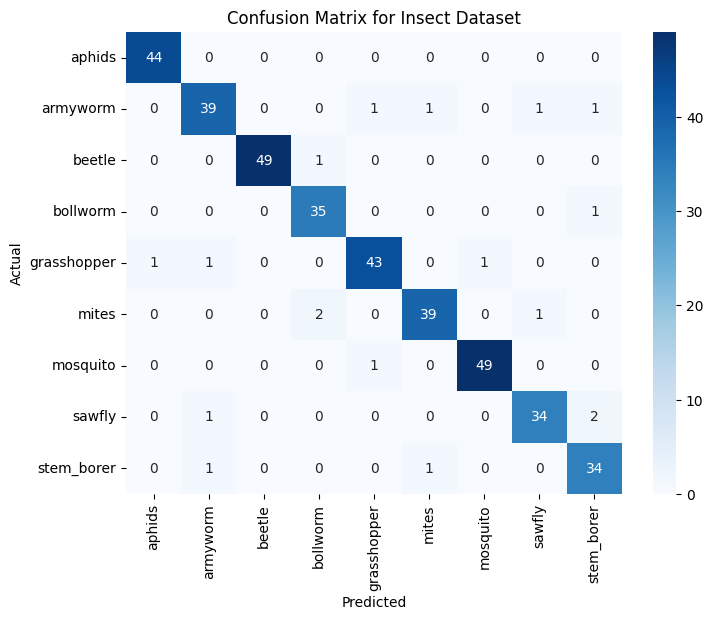

Classification Report:
              precision    recall  f1-score   support

      aphids       0.98      1.00      0.99        44
    armyworm       0.93      0.91      0.92        43
      beetle       1.00      0.98      0.99        50
    bollworm       0.92      0.97      0.95        36
 grasshopper       0.96      0.93      0.95        46
       mites       0.95      0.93      0.94        42
    mosquito       0.98      0.98      0.98        50
      sawfly       0.94      0.92      0.93        37
  stem_borer       0.89      0.94      0.92        36

    accuracy                           0.95       384
   macro avg       0.95      0.95      0.95       384
weighted avg       0.95      0.95      0.95       384



In [45]:
# Set model to evaluation mode
model.eval()

# Lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Insect Dataset')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

In [ ]:
# from PIL import Image
# import torchvision.transforms as transforms

# # Define the same transformations used during training
# transform = transforms.Compose([
#     transforms.Resize((150, 150)),  # Resize to match training data
#     transforms.ToTensor(),          # Convert to tensor
# ])

# # Load the image
# image_path = 'Beetle-1.jpeg'  # Replace with the path to your image
# image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format

# # Preprocess the image
# input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
# input_tensor = input_tensor.to(device)  # Move to the same device as the model

In [ ]:
# # Set the model to evaluation mode
# model.eval()

# # Disable gradient computation
# with torch.no_grad():
#     # Forward pass
#     outputs = model(input_tensor)

#     # Get the predicted class index
#     _, predicted_class = torch.max(outputs, 1)
#     predicted_class = predicted_class.item()  # Convert to a Python integer

In [ ]:
# # Get the class names from the dataset
# class_names = train_dataset.classes

# # Print the predicted class
# predicted_class_name = class_names[predicted_class]
# print(f'The predicted class is: {predicted_class_name}')

The predicted class is: beetle


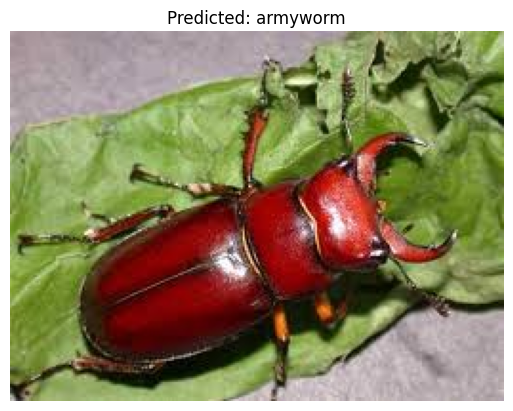

In [51]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to match training data
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.54804652, 0.55568446, 0.41112162], std= [0.27338607, 0.25383742, 0.28720645])
])

# Load the image
image_path = 'beetle-2.jpeg'  # Replace with the path to your image
image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format

# Preprocess the image
input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
input_tensor = input_tensor.to(device)  # Move to the same device as the model

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    outputs = model(input_tensor)

    # Get the predicted class index
    _, predicted_class = torch.max(outputs, 1)
    predicted_class = predicted_class.item()  # Convert to a Python integer

# Get the class names from the dataset
class_names = train_dataset.classes

# Print the predicted class
predicted_class_name = class_names[predicted_class]

# Display the image with the predicted class as the title
plt.imshow(image)
plt.title(f'Predicted: {predicted_class_name}')
plt.axis('off')  
plt.show()

In [52]:
torch.save(model.state_dict(), 'insect_cnn.pth')